In [5]:
pip install phaseportrait

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 KB 5.0 MB/s eta 0:00:00


In [6]:
from phaseportrait import PhasePortrait2D
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.integrate import odeint
from numpy import linalg as LA
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
from numpy import linalg as LA
import plotly.express as px
import pandas as pd

# 2D nonlinear ODE --- determine invarant manifolds numerically then test if they make an eigenfunction

(1) Find fps \\
(2) Find eigenvectors and do TS expansion at fps \\
(3) Select starting values from TS expansion \\
(4) Numerically integrate to determine invariant manifolds \\
(5) Do linear regression to see if there is an eigenfunction


## 2D ODE

In [7]:
def dxdt(x,y):
  dxdt = x-x*y
  return dxdt

def dydt(x,y):
  dydt = -y+x**2-2*y**2
  return dydt

def F(x,y):
    dxvec_dt = [dxdt(x,y), dydt(x,y)];
    return dxvec_dt

def F_alt(x_vec, t):
    x = x_vec[0]
    y = x_vec[1]
    dxvec_dt = [dxdt(x,y), dydt(x,y)];
    return dxvec_dt

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3998c56730>)

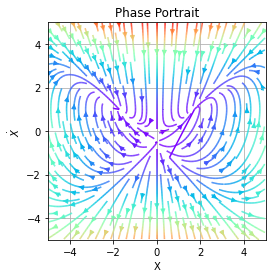

<Figure size 720x720 with 0 Axes>

In [8]:
#########################
###### My system ########
#########################

phase_port = PhasePortrait2D(F, [-5,5])

plt.figure(figsize=(10,10))
phase_port.plot()


In [9]:
fp1 = [0, -1/2]
fp2 = [0, 0]
fp3 = [-math.sqrt(3), 1]
fp4 = [math.sqrt(3), 1]

# eigevectors for fp 3
fp3_eigvec1 = [-1/np.sqrt(3), 1]
fp3_eigvec2 = [-np.sqrt(3)/2, 1]

# eigvectors for fp 4
fp4_eigvec1 = [1/np.sqrt(3), 1]
fp4_eigvec2 = [np.sqrt(3)/2, 1]


## Make M1(x,y) out of first invariant manifold

In [10]:
def fp1_eig1(x):
  fp1_eig1 = -1/2 + 0*x
  return fp1_eig1

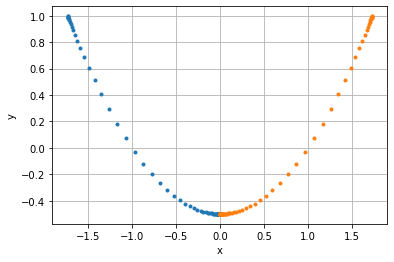

In [11]:
## generate points near fp1 (0,-1/2) ##
num_init_pts = 2
x_init = np.linspace(-0.00001,0.00001, num_init_pts)
y_init = fp1_eig1(x_init)
xy_init = np.stack((x_init,y_init))
t = np.linspace(0, 10, 100)  #np.linspace(0, 10, 101)

sol_list = []

for j in range(num_init_pts):
  y0 = xy_init[:,j]
  sol = odeint(F_alt, y0, t)

  plt.plot(sol[:,0], sol[:,1], '.')
  sol = sol.tolist()
  sol_list.append(sol)

plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()




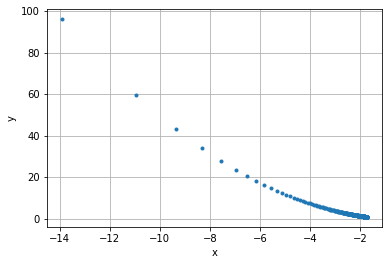

In [12]:
## generate points near fp3 (-sqrt(3),1) ##
vec1 = np.stack((fp3, np.array(fp3)+0.0001*np.array(fp3_eigvec1)), axis=0)
xy_init = np.transpose(vec1)
t = np.linspace(0, -3.2, 1000)  #np.linspace(0, 10, 101)
num_init_pts = 2

for j in range(1,num_init_pts):
  y0 = xy_init[:,j]
  sol = odeint(F_alt, y0, t)

  plt.plot(sol[:,0], sol[:,1], '.')
  sol = sol.tolist()
  sol_list.append(sol)

plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()


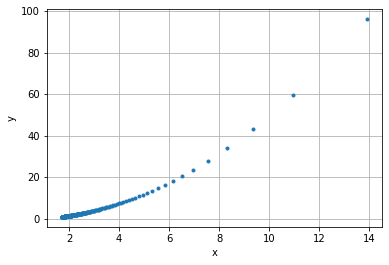

In [13]:
## generate points near fp4 (sqrt(3),1) ##
vec1 = np.stack((fp4, np.array(fp4)+0.0001*np.array(fp4_eigvec1)), axis=0)
xy_init = np.transpose(vec1)
t = np.linspace(0, -3.2, 1000)  #np.linspace(0, 10, 101)
num_init_pts = 2

for j in range(1,num_init_pts):
  y0 = xy_init[:,j]
  sol = odeint(F_alt, y0, t)

  plt.plot(sol[:,0], sol[:,1], '.')
  sol = sol.tolist()
  sol_list.append(sol)

plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

(-1.0, 20.0)

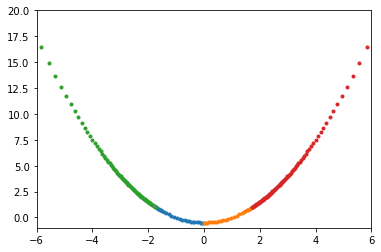

In [14]:
## get rid of some of points ##
for i in range(0,4):
  sol = sol_list[i]

  range_max = len(sol)-1
  j = 0

  while j < range_max:
    #print(j)
    norm_tmp = 0
    while norm_tmp < 0.05:
      if j >= range_max-1:
          break
      diff_vec = np.array(sol[j])-np.array(sol[j+1])
      norm_tmp = LA.norm(diff_vec)
      range_max = len(sol)-1
      if norm_tmp <0.05:
        sol.pop(j+1)

    j = j+1


vec1 = np.stack((fp3, np.array(fp3)+0.1*np.array(fp3_eigvec1)), axis=0)

sol1 = np.array(sol_list[0])
sol2 = np.array(sol_list[1])
sol3 = np.array(sol_list[2])
sol4 = np.array(sol_list[3])
plt.figure()
plt.plot(sol1[:,0], sol1[:,1], '.')
plt.plot(sol2[:,0], sol2[:,1], '.')
plt.plot(sol3[:,0], sol3[:,1], '.')
plt.plot(sol4[:,0], sol4[:,1], '.')

plt.plot(vec1[:,0], vec1[:,1])

plt.xlim([-6,6])
plt.ylim([-1,20])

#plt.xlim([-4,0])
#plt.ylim([0,2])

In [15]:
sol_list[2].reverse()
sol_list[0].reverse()

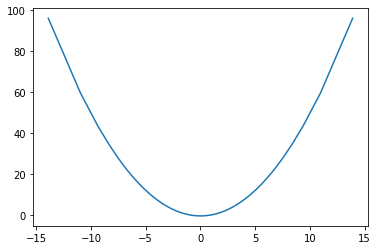

In [16]:
all_points = sol_list[2] + sol_list[0] + sol_list[1] + sol_list[3]
all_points = np.array(all_points)

plt.figure()
plt.plot(all_points[:,0],all_points[:,1])

#plt.xlim([-5,5])
#plt.ylim([-1,2])

## Interpolate points on manifold 1

In [17]:
## interpolate points ##
m1 = interp1d(all_points[:,0], all_points[:,1], kind='cubic')

## derivative of m1 ##
m1_deriv = m1._spline.derivative(nu=1)

def M1(x,y):
  z=y-m1(x)
  return z

def N1(x,y):
  z = (dydt(x,y) - m1_deriv(x).flatten()*dxdt(x,y))/(y-m1(x))
  #z = (dydt(x,y) - dxdt(x,y))/(y-m1(x))
  return z


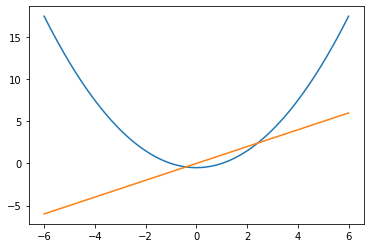

In [18]:
xtest = np.linspace(-6,6,100)
plt.plot(xtest, m1(xtest))
plt.plot(xtest, m1_deriv(xtest))

/usr/local/lib/python3.8/dist-packages/mpl_toolkits/mplot3d/art3d.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._segments3d = np.asanyarray(segments)


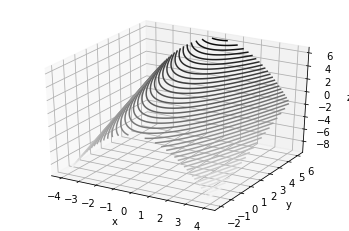

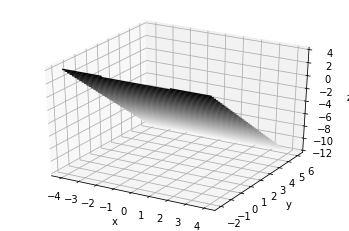

In [20]:
### Plot M1  ###
x = np.linspace(-4, 4, 60)
y = np.linspace(-2, 6, 60)

X, Y = np.meshgrid(x, y)
Z = M1(X, Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

### Plot N1  ###
X = np.reshape(X, (1,-1))
Y = np.reshape(Y, (1,-1))

Z = N1(X, Y)

X = np.reshape(X, (60,60))
Y = np.reshape(Y, (60,60))
Z = np.reshape(Z, (60,60))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

## Make M2(x,y) out of 2nd invariant manifold

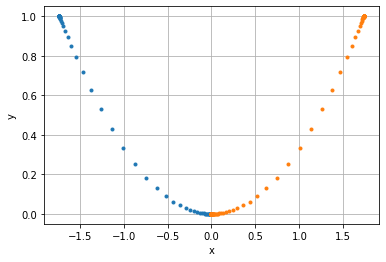

In [21]:
def fp2_eig1(x):
  fp1_eig1 = 0 + 0*x
  return fp1_eig1

## generate points near fp2 (0,0) ##
num_init_pts = 2
x_init = np.linspace(-0.00001,0.00001, num_init_pts)
y_init = fp2_eig1(x_init)
xy_init = np.stack((x_init,y_init))
t = np.linspace(0, 20, 100)  #np.linspace(0, 10, 101)

sol_list = []

for j in range(num_init_pts):
  y0 = xy_init[:,j]
  sol = odeint(F_alt, y0, t)

  plt.plot(sol[:,0], sol[:,1], '.')
  sol = sol.tolist()
  sol_list.append(sol)

plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()


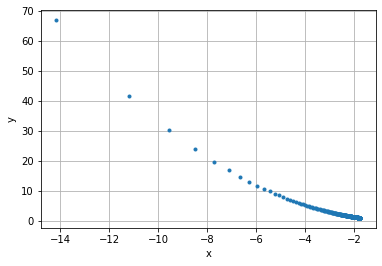

In [22]:
## generate points near fp3 (-sqrt(3),1) ##
vec1 = np.stack((fp3, np.array(fp3)+0.0001*np.array(fp3_eigvec2)), axis=0)
xy_init = np.transpose(vec1)
t = np.linspace(0, -4.6, 1000)  #np.linspace(0, 10, 101)
num_init_pts = 2

for j in range(1,num_init_pts):
  y0 = xy_init[:,j]
  sol = odeint(F_alt, y0, t)

  plt.plot(sol[:,0], sol[:,1], '.')
  sol = sol.tolist()
  sol_list.append(sol)

plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

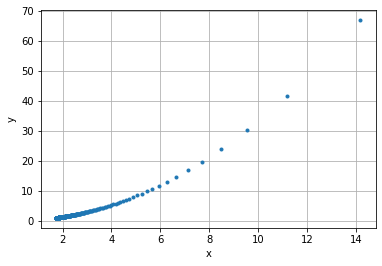

In [23]:
## generate points near fp4 (sqrt(3),1) ##
vec1 = np.stack((fp4, np.array(fp4)+0.0001*np.array(fp4_eigvec2)), axis=0)
xy_init = np.transpose(vec1)
t = np.linspace(0, -4.6, 1000)  #np.linspace(0, 10, 101)
num_init_pts = 2

for j in range(1,num_init_pts):
  y0 = xy_init[:,j]
  sol = odeint(F_alt, y0, t)

  plt.plot(sol[:,0], sol[:,1], '.')
  sol = sol.tolist()
  sol_list.append(sol)

plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

(-1.0, 20.0)

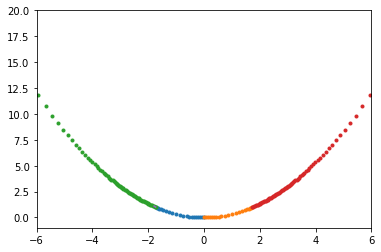

In [24]:
## get rid of some of points ##
for i in range(0,4):
  sol = sol_list[i]

  range_max = len(sol)-1
  j = 0

  while j < range_max:
    #print(j)
    norm_tmp = 0
    while norm_tmp < 0.05:
      if j >= range_max-1:
          break
      diff_vec = np.array(sol[j])-np.array(sol[j+1])
      norm_tmp = LA.norm(diff_vec)
      range_max = len(sol)-1
      if norm_tmp <0.05:
        sol.pop(j+1)

    j = j+1


vec1 = np.stack((fp3, np.array(fp3)+0.1*np.array(fp3_eigvec1)), axis=0)

sol1 = np.array(sol_list[0])
sol2 = np.array(sol_list[1])
sol3 = np.array(sol_list[2])
sol4 = np.array(sol_list[3])
plt.figure()
plt.plot(sol1[:,0], sol1[:,1], '.')
plt.plot(sol2[:,0], sol2[:,1], '.')
plt.plot(sol3[:,0], sol3[:,1], '.')
plt.plot(sol4[:,0], sol4[:,1], '.')

plt.plot(vec1[:,0], vec1[:,1])

plt.xlim([-6,6])
plt.ylim([-1,20])

#plt.xlim([-4,0])
#plt.ylim([0,2])

In [25]:
sol_list[2].reverse()
sol_list[0].reverse()

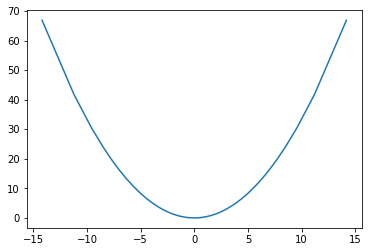

In [26]:
all_points2 = sol_list[2] + sol_list[0] + sol_list[1] + sol_list[3]
all_points2 = np.array(all_points2)

plt.figure()
plt.plot(all_points2[:,0],all_points2[:,1])

## Interpolate points on manifold 2

In [27]:
## interpolate points ##
m2 = interp1d(all_points2[:,0], all_points2[:,1], kind='cubic')

## derivative of m2 ##
m2_deriv = m2._spline.derivative(nu=1)

def M2(x,y):
  z=y-m2(x)
  return z

def N2(x,y):
  z = (dydt(x,y) - m2_deriv(x).flatten()*dxdt(x,y))/(y-m2(x))
  return z

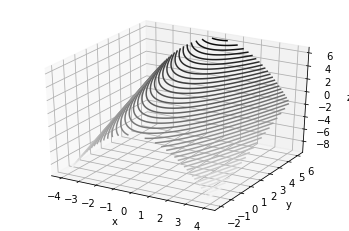

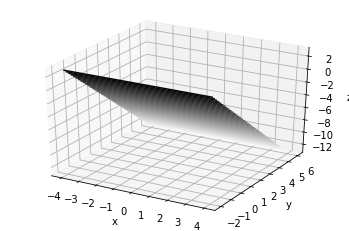

In [28]:
x = np.linspace(-4, 4, 60)
y = np.linspace(-2, 6, 60)

X, Y = np.meshgrid(x, y)
Z = M1(X, Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

### Plot N2  ###
X = np.reshape(X, (1,-1))
Y = np.reshape(Y, (1,-1))

Z = N2(X, Y)

X = np.reshape(X, (60,60))
Y = np.reshape(Y, (60,60))
Z = np.reshape(Z, (60,60))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

## Make M3(x,y) out of 3rd invariant manifold

In [29]:
## interpolate points ##

################################
###  dxdt = f1,   dydt = f2  ###
################################

def M3(x,y):
  z=x
  return z

def N3(x,y):
  z = dxdt(x,y)/(x)
  return z

## Test eigenfunction

In [35]:
num_samps=1000

xtest = np.random.uniform(-8, 8, num_samps)
ytest = np.random.uniform(-4,8,num_samps)

ones_vec = np.ones(num_samps)

out1 = np.reshape(N1(xtest,ytest),(-1,1))
out2 = np.reshape(N2(xtest,ytest),(-1,1))
out3 = np.reshape(N3(xtest,ytest),(-1,1))

mat = np.hstack((out1, out2, out3))

Text(0.5, 1.0, 'invariant manifolds and regression points')

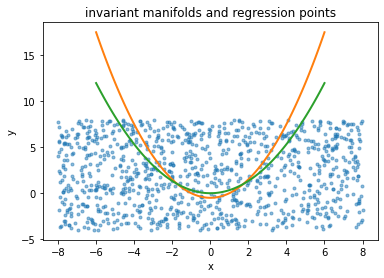

In [36]:
xt = np.linspace(-6,6,100)

plt.plot(xtest,ytest,'.', alpha=0.5)
plt.plot(xt, m1(xt),linewidth=2)
plt.plot(xt, m2(xt),linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('invariant manifolds and regression points')

In [37]:
model = LinearRegression(fit_intercept=False).fit(mat,ones_vec)

out = model.coef_
print(out)

print(model.intercept_)

print(LA.norm(ones_vec - np.matmul(mat,out), 2))

[-4.99721403e-01 -1.85429325e-04  9.99813837e-01]
0.0
0.0001748770622628714


Text(0.5, 1.0, 'p1*N1(x,y) + p2*N2(x,y) + p3*N3(x,y)')

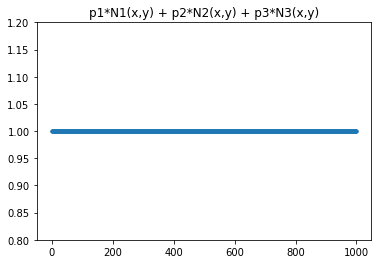

In [44]:
plt.plot(np.matmul(mat,out),'.')
plt.ylim([0.8,1.2])
plt.title('p1*N1(x,y) + p2*N2(x,y) + p3*N3(x,y)')

## Visualize combination of N(x,y) functions

/usr/local/lib/python3.8/dist-packages/mpl_toolkits/mplot3d/art3d.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._segments3d = np.asanyarray(segments)


(0.8, 1.2)

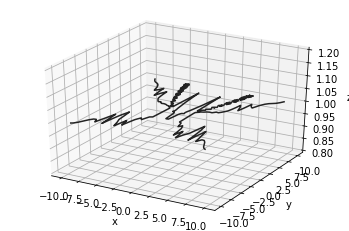

In [40]:
### Plot M1  ###
x = np.linspace(-10, 10, 60)
y = np.linspace(-10, 10, 60)

X, Y = np.meshgrid(x, y)

### Plot N1  ###
X = np.reshape(X, (1,-1))
Y = np.reshape(Y, (1,-1))

Z = out[0]*N1(X, Y) + out[1]*N2(X, Y) + out[2]*N3(X, Y) 

X = np.reshape(X, (60,60))
Y = np.reshape(Y, (60,60))
Z = np.reshape(Z, (60,60))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
ax.set_zlim(0.8,1.2)

In [43]:
X = X.flatten()
Y = Y.flatten()
Z = Z.flatten()

d = {'x': X, 'y': Y, 'linear combo N(x,y)': Z}
df = pd.DataFrame(data=d)


fig = px.scatter_3d(df, x='x', y='y', z='linear combo N(x,y)', opacity=0.5)
fig.update_traces(marker_size=3)
fig.show()